In [9]:
import matplotlib.pyplot as plt
import numpy as np
from pycbc import psd as pypsd
from pycbc.inference.models import GaussianNoise
from pycbc.noise.gaussian import frequency_noise_from_psd
from pycbc.waveform.generator import (FDomainDetFrameGenerator,FDomainCBCGenerator)
from pycbc.psd import EinsteinTelescopeP1600143


In [ ]:
seglen = 4
sample_rate = 2048

N = int(seglen * sample_rate / 2 + 1) # Number of samples in the frequency series

fmin = 5.

# Paramètres d'un signal de CBC (16 en tout)
cbc_params = {
              # Paramètres intrinsèques à la source
              'mass1': 38.6,
              'mass2': 29.3,
              'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': 0., 'spin2z': 0.,
              'eccentricity': 0,
              # Paramètres extrinsèques
              'ra': 1.37, 'dec': -1.26, 'distance': 1000,
              'polarization': 2.76, 'inclination': 0,
              'tc': 3.1 , 'coa_phase': 0}

para_reels = np.array([3.1, 38.6, 29.3, 1000, 1.37, -1.26])

cbc_params['approximant'] = 'IMRPhenomD'
#IMRPhenomXAS (modèle plus simple)
cbc_params['f_lower'] =  fmin

In [3]:
# Définition du générateur
generator = FDomainDetFrameGenerator(
    FDomainCBCGenerator, 0., detectors=['H1', 'L1'],
    delta_f=1./seglen, **cbc_params)

# Génération du signal
signal = generator.generate()
print(signal)

{'H1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7f2172b56790>, 'L1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7f20e795bcd0>}


/home/victor-glorieux/.conda/envs/cop_adrian/lib/python3.9/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other


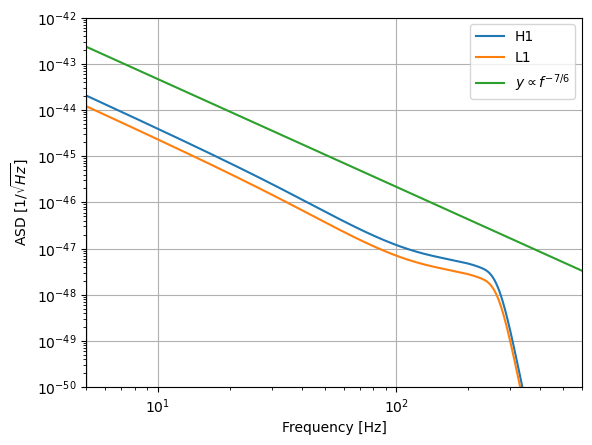

In [4]:
plt.loglog(signal['H1'].get_sample_frequencies(), np.abs(signal['H1'])**2,label='H1')
plt.loglog(signal['L1'].get_sample_frequencies(), np.abs(signal['L1'])**2, label='L1')

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'ASD [1/$\sqrt{Hz}]$')
y = signal['H1'].get_sample_frequencies()**(-7/3)
plt.loglog(signal['H1'].get_sample_frequencies(), 1e-41*y, label=r'$y\propto f^{-7/6}$')
plt.legend()
plt.ylim(1e-50, 1e-42)
plt.xlim(5, 600)
plt.grid()

### Signal sans buit

In [5]:
psd = EinsteinTelescopeP1600143(N, 1./seglen, fmin)
psds = {'H1': psd, 'L1': psd}
low_frequency_cutoff = {'H1': fmin, 'L1': fmin}

model = GaussianNoise(['mass1', 'mass2', 'tc'], signal, low_frequency_cutoff,
                          psds=psds, static_params=cbc_params)

### Signal avec bruit

In [ ]:
psd = EinsteinTelescopeP1600143(N, 1./seglen, fmin)
psds = {'H1': psd, 'L1': psd}
low_frequency_cutoff = {'H1': fmin, 'L1': fmin}

# Generate noise and add it to the signal
noise = frequency_noise_from_psd(psd)
signal = signal + noise
model = GaussianNoise(['mass1', 'mass2', 'tc'], signal, low_frequency_cutoff,
                          psds=psds, static_params=cbc_params)

In [6]:
model.update()
print('Log likelihood: {:.2f}'.format(model.loglikelihood))
print('Log likelihood noise: {:.2f}'.format(model.lognl))
print('Log likelihood ratio: {:.2f}'.format(model.loglr))

Log likelihood: 0.00
Log likelihood noise: -179203.23
Log likelihood ratio: 179203.23


In [7]:
snr_H1_sq = model.det_optimal_snrsq('H1')
snr_L1_sq = model.det_optimal_snrsq('L1')

log_noise_likelihood_from_SNR = -0.5 * (snr_H1_sq + snr_L1_sq)

print('SNR H1: {:.2f}'.format(snr_H1_sq**0.5))
print('SNR L1: {:.2f}'.format(snr_L1_sq**0.5))

print('Expected log likelihood noise: {:.2f}'.format(log_noise_likelihood_from_SNR))

SNR H1: 474.95
SNR L1: 364.46
Expected log likelihood noise: -179203.23


### Variation d'un paramètre

On fait varier $t_c$ ici et on vérifie que la max du likelihood soit atteint pour sa bonne valeur.

In [12]:
tsig = 3.1
tc_test = np.arange(tsig-1, tsig+1, 0.1)
ll_ratio_test = np.zeros_like(tc_test)

for i, t in enumerate(tc_test):
    model.update(tc=t)
    ll_ratio_test[i] = model.loglr

Text(0, 0.5, 'Log($\\mathcal{L}$) ratio')

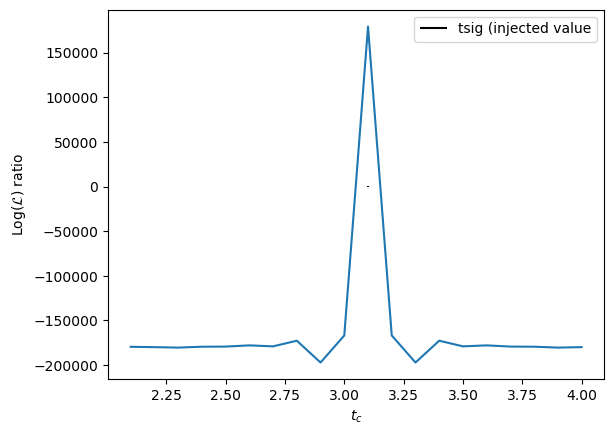

In [13]:
plt.plot(tc_test, ll_ratio_test)
plt.vlines(tsig, -300, 300, color='black', label="tsig (injected value")
plt.legend()
plt.xlabel(r"$t_c$")
plt.ylabel(r"Log($\mathcal{L}$) ratio")

### Minimisation en utilisant un DataFrame : minimums LOCAUX

Facilité la récupération des données.
Paramètres : $t_c$, $m_1$, $m_2$, $d_L$, ra, dec.
Fonction scipy.optimize.minimize.

In [ ]:
from scipy.optimize import minimize
import pandas as pd

params_dataFrame = pd.DataFrame(data={'mloglik': [],'tc': [], 'mass1': [],
                                     'mass2': [], 'distance': [], 'ra' : [], 'dec' : []})
k=0

def likelihood_calculation(params):

    global params_dataFrame, k
    model.update(tc=params[0],mass1=params[1],mass2=params[2],distance=params[3],ra=params[4],dec=params[5])
    mloglik = - model.loglr

    add = pd.DataFrame(data={'mloglik': mloglik, 'tc': params[0], 'mass1': params[1],
                             'mass2': params[2], 'distance': params[3], 'ra' : params[4],
                             'dec' : params[5]},index=[k])
    params_dataFrame = pd.concat([params_dataFrame,add])
    k +=1

    print (mloglik, end="\r")
    time.sleep(0.1)

    return mloglik

#true params : (tc=3.1, mass1=38.6, mass2=29.3, distance = 1000, ra = 1.37, dec = -1.26)
initial_params = [3.1, 38.6, 29.3, 1000, 1.37, -1.26]
#Nelder-Mead
bounds=((2,4),(20,40),(20,40),(900,1100),(-2,2),(-2,2))
result = minimize(likelihood_calculation, method = 'Nelder-Mead', bounds=bounds, x0=initial_params, tol=1e-3)

In [61]:
para_opti = result.x
print('Paramètres initiaux :')
print('$t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}.'.format(initial_params[0],
     initial_params[1], initial_params[2], initial_params[3], initial_params[4], initial_params[5]))
print('\nParamètres d\'optimisation trouvés (local) :')
print('$t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}.'.format(para_opti[0],
     para_opti[1], para_opti[2], para_opti[3], para_opti[4], para_opti[5]))
print('\nParamètres réels :')
print('$t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}.'.format(para_reels[0],
     para_reels[1], para_reels[2], para_reels[3], para_reels[4], para_reels[5]))

Paramètres initiaux :
$t_c$ : 3.1, $m_1$ : 38.6, $m_2$ : 29.3, $d_L$ : 1000, ra : 1.37, dec : -1.26.

Paramètres d'optimisation trouvés (local) :
$t_c$ : 3.0999999999232157, $m_1$ : 38.60000002437903, $m_2$ : 29.299999981688376, $d_L$ : 1000.0000057776317, ra : 1.3700000037220503, dec : -1.260000011743196.

Paramètres réels :
$t_c$ : 3.1, $m_1$ : 38.6, $m_2$ : 29.3, $d_L$ : 1000.0, ra : 1.37, dec : -1.26.


Création des listes associées aux paramètres à partir du DataFrame. Premier plot de l'évolution de la minimisation $t_c$ et $m_1$.

/tmp/ipykernel_2072749/680909320.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axhline(float(data_tail['mass1']),linestyle = 'dashed',color='r')
/tmp/ipykernel_2072749/680909320.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(float(data_tail['tc']),linestyle = 'dashed',color='r')


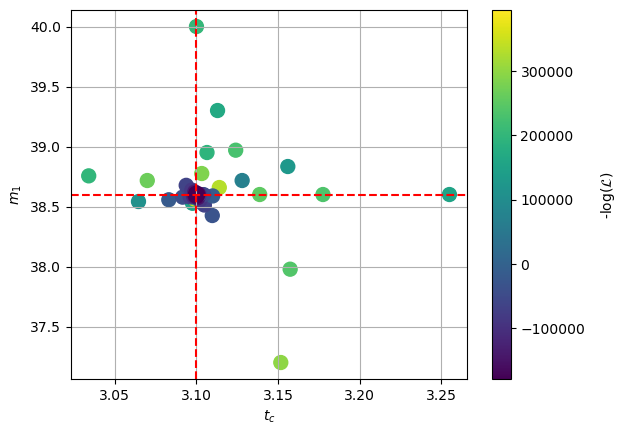

In [59]:
tc_list=params_dataFrame['tc']
mass1_list=params_dataFrame['mass1']
mass2_list=params_dataFrame['mass2']
distance_list=params_dataFrame['distance']
ra_list=params_dataFrame['ra']
dec_list=params_dataFrame['dec']
ll_ratio_test=params_dataFrame['mloglik']

plt.scatter(tc_list, mass1_list, c=ll_ratio_test, cmap='viridis', s=100)
plt.xlabel(r'$t_c$')
plt.ylabel(r'$m_1$')
plt.grid()
data_tail = params_dataFrame.tail(1)
plt.axhline(float(data_tail['mass1']),linestyle = 'dashed',color='r')
plt.axvline(float(data_tail['tc']),linestyle = 'dashed',color='r')
colorbar = plt.colorbar(orientation='vertical')
colorbar.set_label(r'-log($\mathcal{L}$)', labelpad=10)

Plot des graphs d'évolution de la minimisation pour toutes les combinaisons de paramètres associées à notre minimisation : minimums LOCAUX.

/tmp/ipykernel_2072749/3466612611.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.axhline(float(data_tail[data_y]),linestyle = 'dashed',color='r', label=label_y + r'$_{,opt}$ = ' + str(round(float(data_tail[data_y]),2)))
/tmp/ipykernel_2072749/3466612611.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.axvline(float(data_tail[data_x]),linestyle = 'dashed',color='r', label=label_x + r'$_{,opt}$ = ' + str(round(float(data_tail[data_x]),2)))


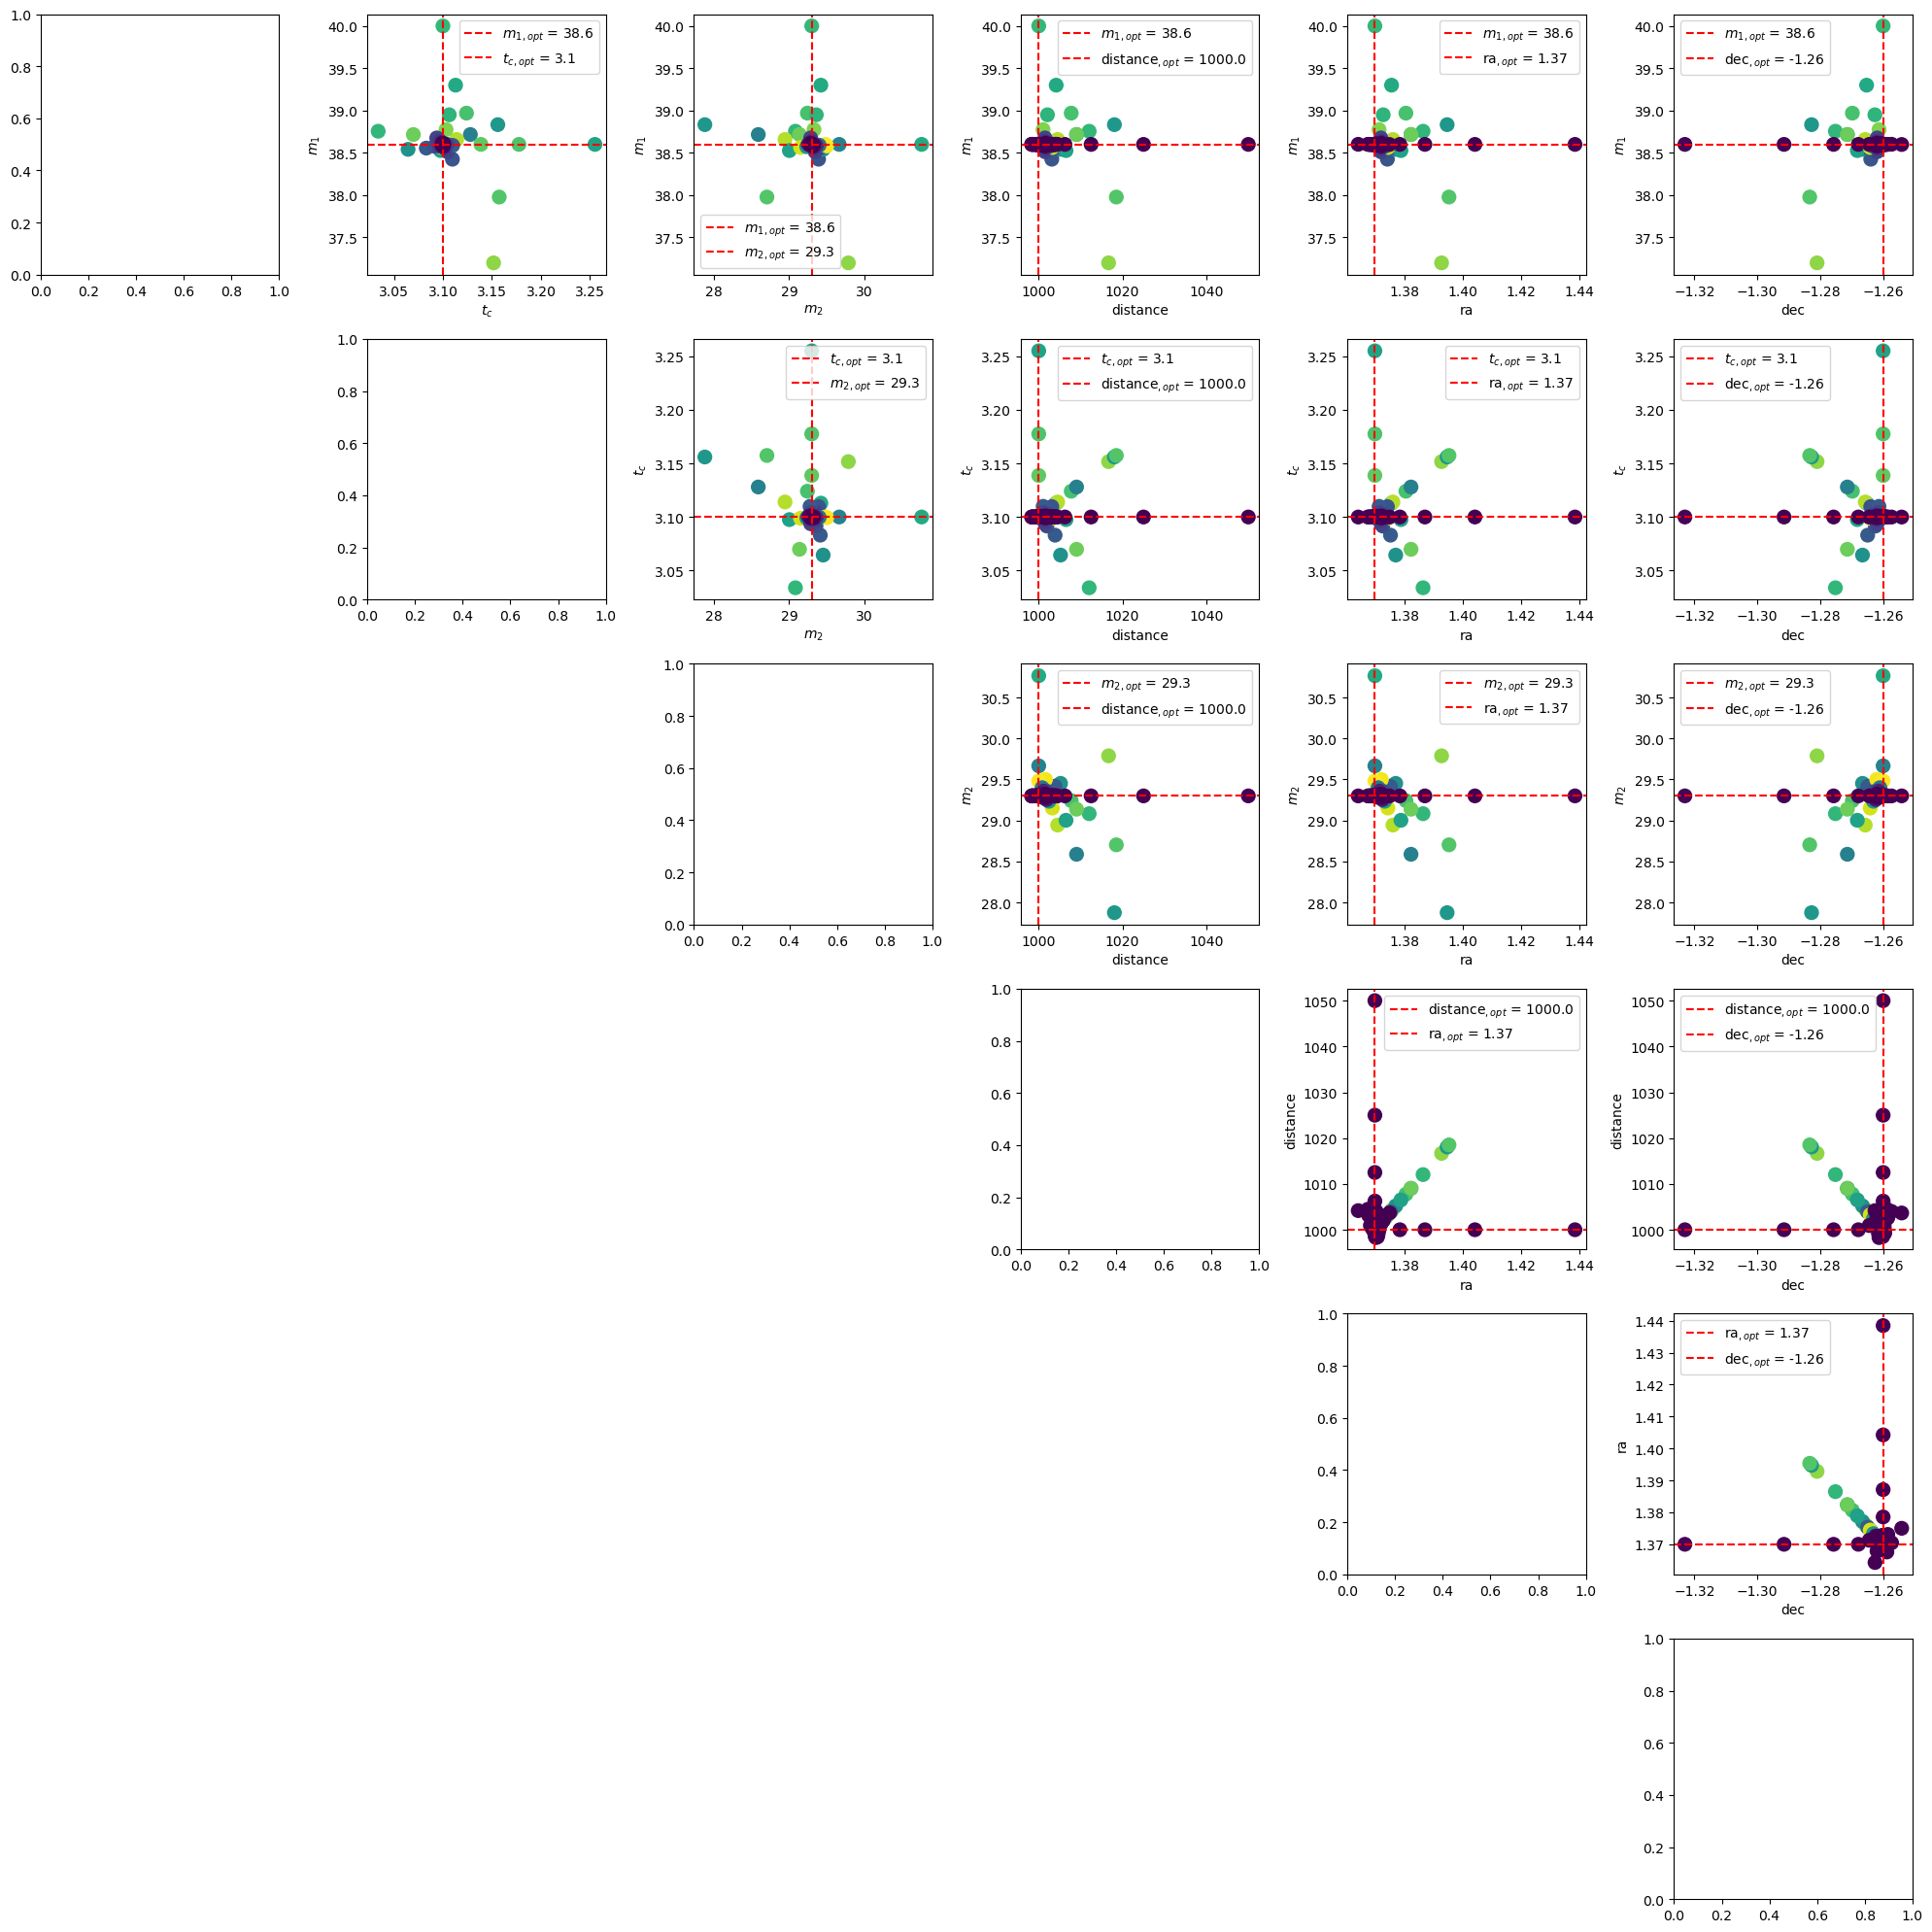

In [60]:
fig, axs = plt.subplots(nrows=6,ncols=6,figsize=(20,20))

def plot_corr(x_list,y_list,label_x,label_y,data_x,data_y,ax,data_tail):
    ax.scatter(x_list, y_list, c=ll_ratio_test, cmap='viridis', s=100)
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)
    ax.axhline(float(data_tail[data_y]),linestyle = 'dashed',color='r', label=label_y + r'$_{,opt}$ = ' + str(round(float(data_tail[data_y]),2)))
    ax.axvline(float(data_tail[data_x]),linestyle = 'dashed',color='r', label=label_x + r'$_{,opt}$ = ' + str(round(float(data_tail[data_x]),2)))
    ax.legend()

axs_list = [axs[0,1], axs[0,2],   axs[0,3],      axs[0,4],   axs[0,5],  axs[1,2],    axs[1,3],      axs[1,4], axs[1,5], axs[2,3],      axs[2,4],   axs[2,5],   axs[3,4],      axs[3,5],      axs[4,5]]
x_list = [tc_list,    mass2_list, distance_list, ra_list,    dec_list,   mass2_list, distance_list, ra_list,  dec_list, distance_list, ra_list,    dec_list,   ra_list,       dec_list,      dec_list]
y_list = [mass1_list, mass1_list, mass1_list,    mass1_list, mass1_list, tc_list,    tc_list,       tc_list,  tc_list,  mass2_list,    mass2_list, mass2_list, distance_list, distance_list, ra_list]
label_x = [r'$t_c$',  r'$m_2$',   r'distance',   r'ra',      r'dec',     r'$m_2$',   r'distance',   r'ra',    r'dec',   r'distance',   r'ra',      r'dec',     r'ra',         r'dec',        r'dec']
label_y = [r'$m_1$',  r'$m_1$',   r'$m_1$',      r'$m_1$',   r'$m_1$',   r'$t_c$',   r'$t_c$',      r'$t_c$', r'$t_c$', r'$m_2$',      r'$m_2$',   r'$m_2$',   r'distance',   r'distance',   r'ra']
data_x = ['tc',       'mass2',    'distance',    'ra',       'dec',      'mass2',    'distance',    'ra',     'dec',    'distance',    'ra',       'dec',      'ra',          'dec',         'dec']
data_y = ['mass1',    'mass1',    'mass1',       'mass1',    'mass1',    'tc',       'tc',          'tc',     'tc',     'mass2',       'mass2',     'mass2',    'distance',    'distance',    'ra']

for i in range(len(axs_list)):
    plot_corr(x_list[i],y_list[i],label_x[i],label_y[i],data_x[i],data_y[i],axs_list[i],data_tail)

fig.tight_layout()



axs_off = [axs[1,0],axs[2,0],axs[3,0],axs[4,0],axs[5,0],axs[2,1],axs[3,1],axs[3,2],axs[4,1],axs[4,2], axs[4,3],
           axs[5,1],axs[5,2], axs[5,3], axs[5,4]]
for i in axs_off:
    i.axis('off')

In [62]:
plt.savefig("Minimisation_locaux_signal")

<Figure size 640x480 with 0 Axes>

### Minimisation en utilisant un DataFrame : minimums GLOBAUX

On utilise cette fois la fonction scipy.optimize.basinhopping.

In [35]:
import pandas as pd
from scipy.optimize import basinhopping
import time
print('Expected log likelihood noise: {:.2f}'.format(log_noise_likelihood_from_SNR))

params_dataFrame_glob = pd.DataFrame(data={'mloglik': [],'tc': [], 'mass1': [],
                                     'mass2': [], 'distance': [], 'ra' : [], 'dec' : []})
k=0

def likelihood_calculation_glob(params):

    global params_dataFrame_glob, k
    model.update(tc=params[0],mass1=params[1],mass2=params[2],distance=params[3],ra=params[4],dec=params[5])
    mloglik = - model.loglr

    add = pd.DataFrame(data={'mloglik': mloglik, 'tc': params[0], 'mass1': params[1],
                             'mass2': params[2], 'distance': params[3], 'ra' : params[4],
                             'dec' : params[5]},index=[k])
    params_dataFrame_glob = pd.concat([params_dataFrame_glob,add])
    k +=1

    print (mloglik, end="\r")
    time.sleep(0.1)

    return mloglik

#true params : (tc=3.1, mass1=38.6, mass2=29.3, distance = 1000, ra = 1.37, dec = -1.26)
initial_params = [3.1, 38.6, 29.3, 1000, 1.37, -1.26]
#Nelder-Mead
bounds=((0,5),(5,500),(5,500),(10,10000),(-2,2),(-2,2))
#minimizer_kwargs = dict(method="L-BFGS-B")
minimizer_kwargs={ "method": "Nelder-Mead","bounds":bounds, 'tol' : 10e-2 }
result_glob = basinhopping(likelihood_calculation_glob, x0=initial_params, minimizer_kwargs=minimizer_kwargs,niter = 1)

Expected log likelihood noise: -179203.23


Visualisation des paramètres après optimisation.

In [37]:
para_opti = result_glob.x

print('Paramètres initiaux :')
print(r'$t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}.'.format(initial_params[0],
     initial_params[1], initial_params[2], initial_params[3], initial_params[4], initial_params[5]))
print('\nParamètres d\'optimisation trouvés (global) :')
print(r'$t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}.\n'.format(para_opti[0],
     para_opti[1], para_opti[2], para_opti[3], para_opti[4], para_opti[5]))
print('\nParamètres réels :')
print(r'$t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}.\n'.format(para_reels[0],
     para_reels[1], para_reels[2], para_reels[3], para_reels[4], para_reels[5]))

Paramètres initiaux :
$t_c$ : 3.1, $m_1$ : 38.6, $m_2$ : 29.3, $d_L$ : 1000, ra : 1.37, dec : -1.26.

Paramètres d'optimisation trouvés (global) :
$t_c$ : 3.1, $m_1$ : 38.6, $m_2$ : 29.3, $d_L$ : 1000.0, ra : 1.37, dec : -1.26.\n

Paramètres réels :
$t_c$ : 3.1, $m_1$ : 38.6, $m_2$ : 29.3, $d_L$ : 1000.0, ra : 1.37, dec : -1.26.\n


Plot des graphs d'évolution de la minimisation pour toutes les combinaisons de paramètres associées à notre minimisation : minimums LOCAUX + sauvegarde de la figure dans le dossier partagé Github.

mloglik    -179203.227242
tc               3.100000
mass1           38.600000
mass2           29.300000
distance      1000.000000
ra               1.370000
dec             -1.260000
Name: 0, dtype: float64


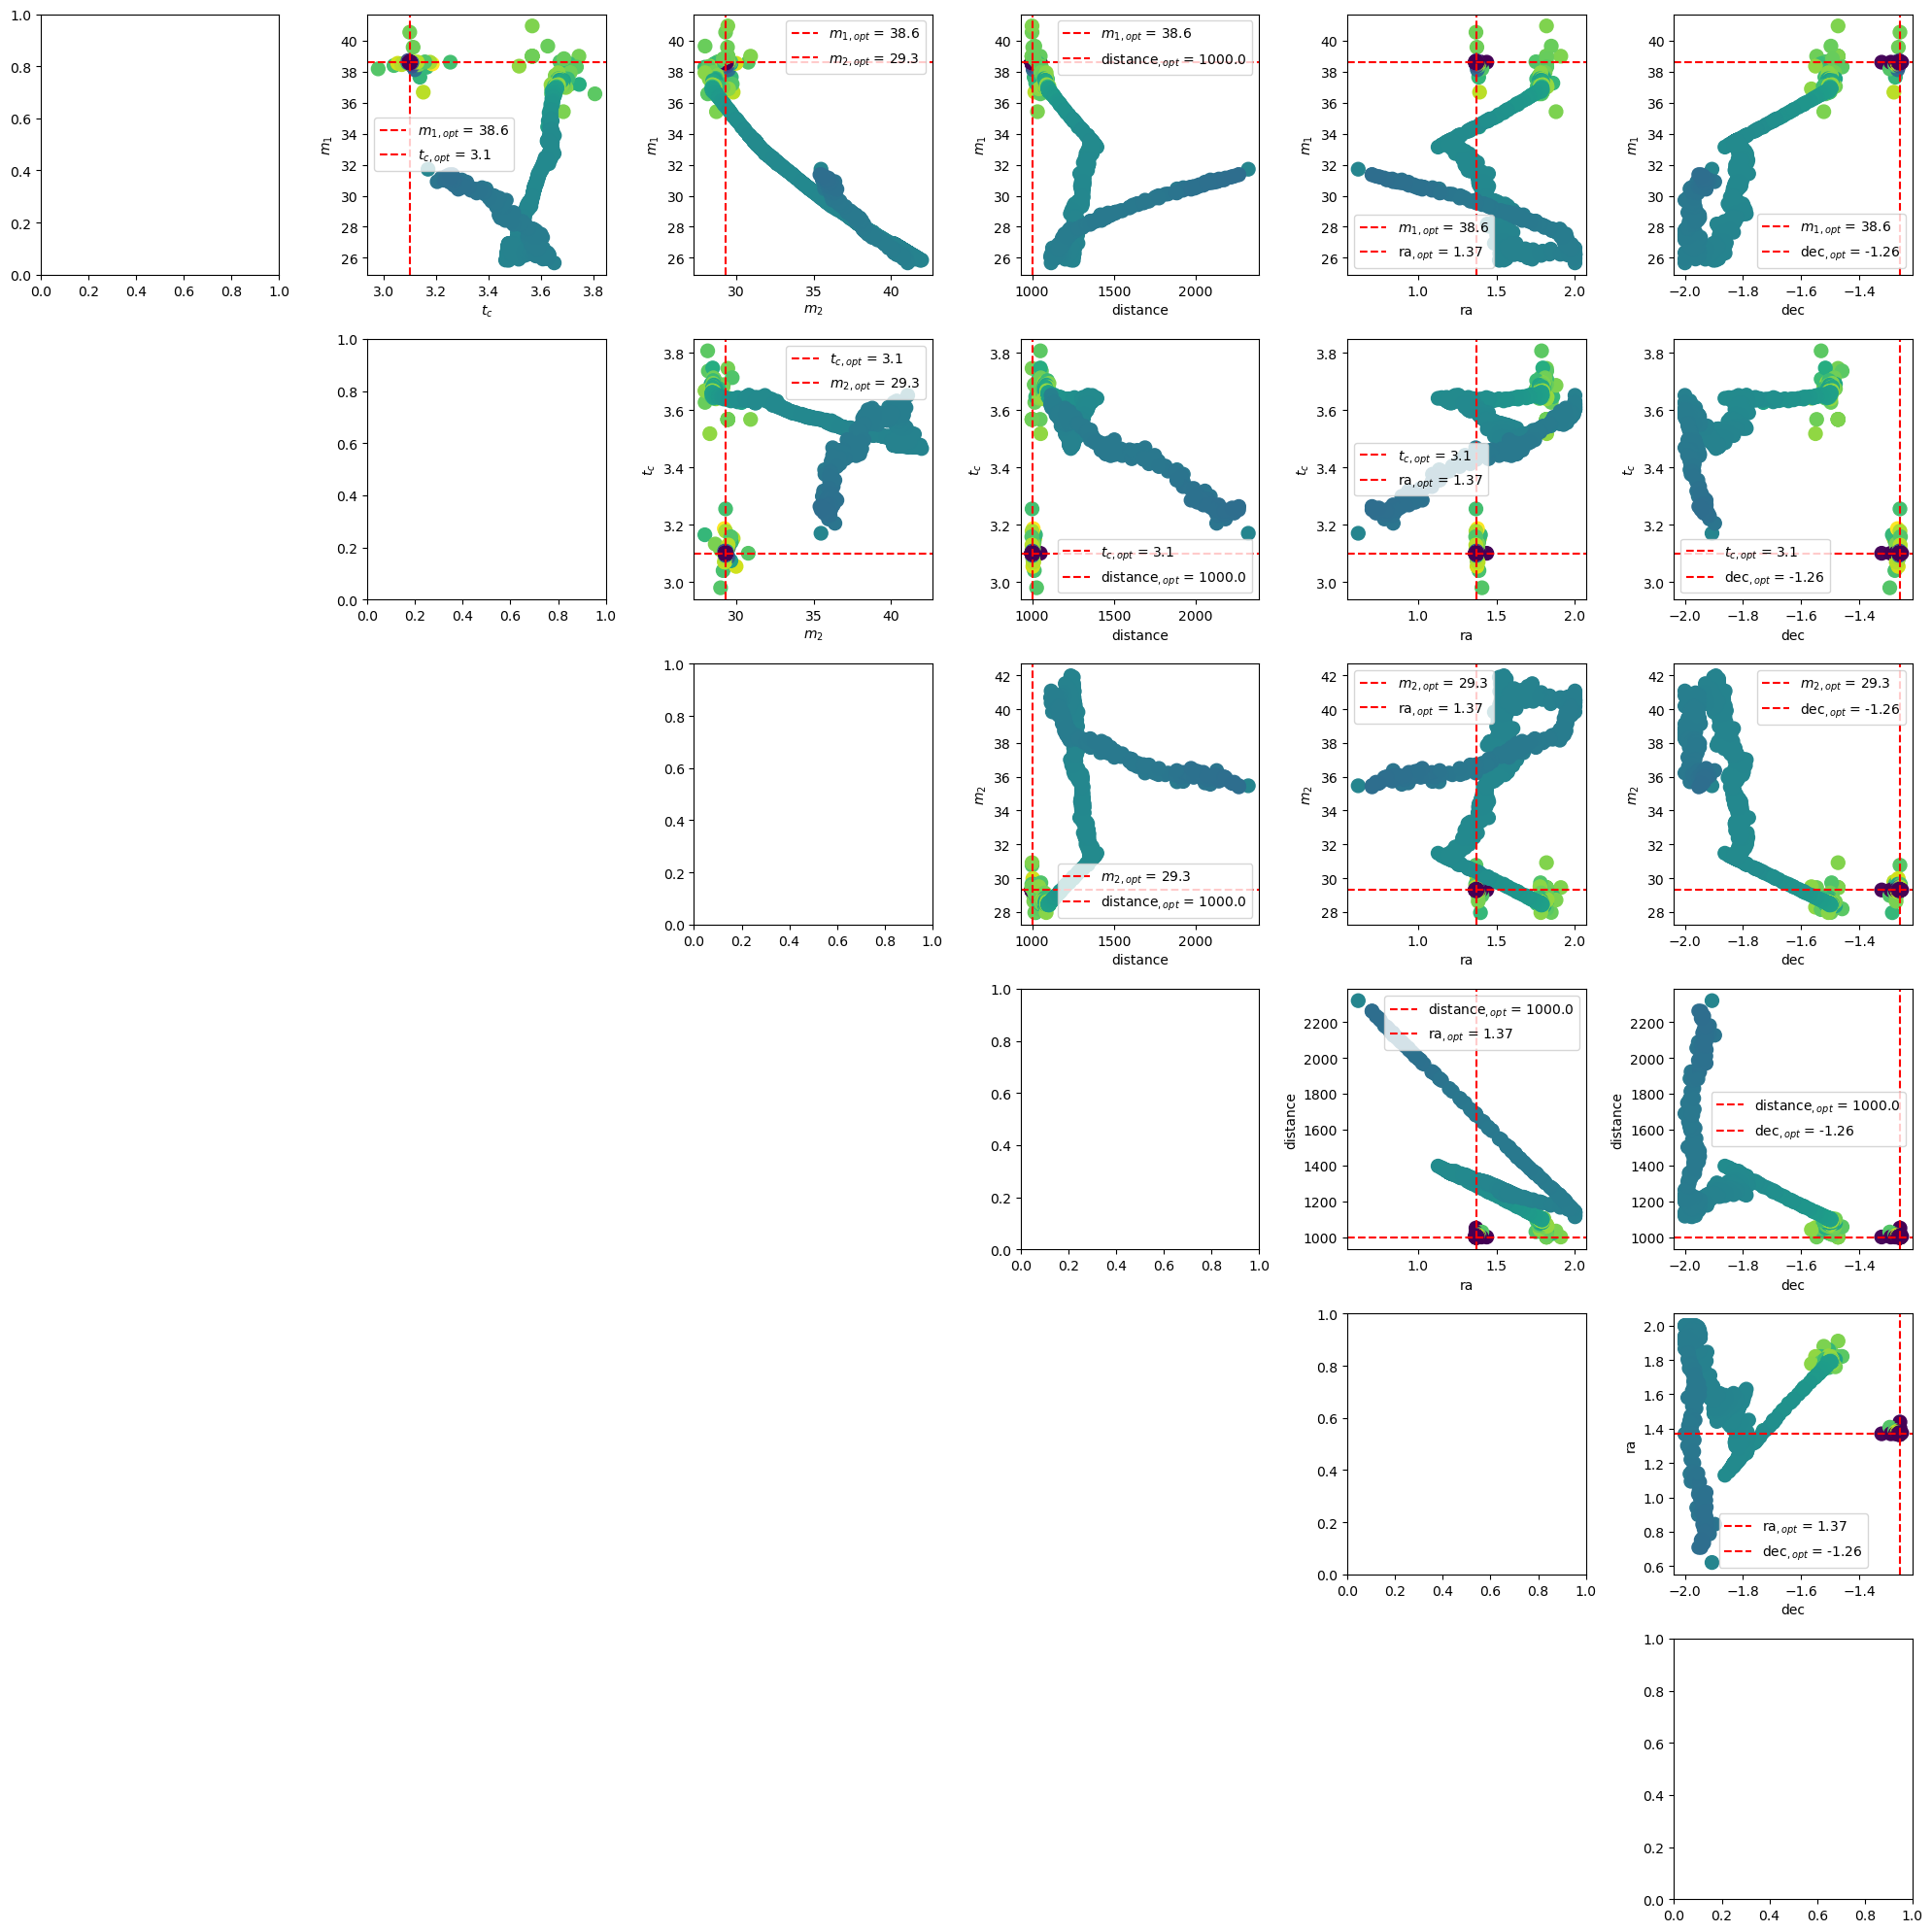

In [56]:
tc_list=params_dataFrame_glob['tc']
mass1_list=params_dataFrame_glob['mass1']
mass2_list=params_dataFrame_glob['mass2']
distance_list=params_dataFrame_glob['distance']
ra_list=params_dataFrame_glob['ra']
dec_list=params_dataFrame_glob['dec']
ll_ratio_test=params_dataFrame_glob['mloglik']


data_tail_glob = params_dataFrame_glob.loc[params_dataFrame_glob['mloglik'].idxmin()]
print(data_tail_glob)

fig_2, axs = plt.subplots(nrows=6,ncols=6,figsize=(20,20))

axs_list = [axs[0,1], axs[0,2],   axs[0,3],      axs[0,4],   axs[0,5],  axs[1,2],    axs[1,3],      axs[1,4], axs[1,5], axs[2,3],      axs[2,4],   axs[2,5],   axs[3,4],      axs[3,5],      axs[4,5]]
x_list = [tc_list,    mass2_list, distance_list, ra_list,    dec_list,   mass2_list, distance_list, ra_list,  dec_list, distance_list, ra_list,    dec_list,   ra_list,       dec_list,      dec_list]
y_list = [mass1_list, mass1_list, mass1_list,    mass1_list, mass1_list, tc_list,    tc_list,       tc_list,  tc_list,  mass2_list,    mass2_list, mass2_list, distance_list, distance_list, ra_list]
label_x = [r'$t_c$',  r'$m_2$',   r'distance',   r'ra',      r'dec',     r'$m_2$',   r'distance',   r'ra',    r'dec',   r'distance',   r'ra',      r'dec',     r'ra',         r'dec',        r'dec']
label_y = [r'$m_1$',  r'$m_1$',   r'$m_1$',      r'$m_1$',   r'$m_1$',   r'$t_c$',   r'$t_c$',      r'$t_c$', r'$t_c$', r'$m_2$',      r'$m_2$',   r'$m_2$',   r'distance',   r'distance',   r'ra']
data_x = ['tc',       'mass2',    'distance',    'ra',       'dec',      'mass2',    'distance',    'ra',     'dec',    'distance',    'ra',       'dec',      'ra',          'dec',         'dec']
data_y = ['mass1',    'mass1',    'mass1',       'mass1',    'mass1',    'tc',       'tc',          'tc',     'tc',     'mass2',       'mass2',     'mass2',    'distance',    'distance',    'ra']

for i in range(len(axs_list)):
    plot_corr(x_list[i],y_list[i],label_x[i],label_y[i],data_x[i],data_y[i],axs_list[i],data_tail_glob)

fig_2.tight_layout()

axs_off = [axs[1,0],axs[2,0],axs[3,0],axs[4,0],axs[5,0],axs[2,1],axs[3,1],axs[3,2],axs[4,1],axs[4,2], axs[4,3],
           axs[5,1],axs[5,2], axs[5,3], axs[5,4]]
for i in axs_off:
    i.axis('off')

In [ ]:
plt.savefig("Minimisation_globaux_signal")

Plot des corrélations des différents paramètres de notre GW. Nous faisons une gille 2D pour chaque combinaison de 2 paramètres (laissés libres) et nous fixons tous les autres à leur valeur réelle.

In [1]:
fig_3, axs = plt.subplots(nrows=6,ncols=6,figsize=(20,20))

def plot_grid_correlation(data_x,data_y,axs_list,label_x,label_y,param_min,param_max):

    model.update(tc=cbc_params['tc'], mass1 = cbc_params['mass1'], mass2 = cbc_params['mass2'],
                distance = cbc_params['distance'], ra = cbc_params['ra'], dec = cbc_params['dec'])

    index_x = params_dataFrame_glob.columns.get_loc(data_x) - 1
    index_y = params_dataFrame_glob.columns.get_loc(data_y) - 1

    x_grid = np.arange(param_min[index_x],param_max[index_x],echantill[index_x])
    y_grid = np.arange(param_min[index_y],param_max[index_y],echantill[index_y])

    print("Iterations totales : ",len(x_grid)*len(y_grid))
    k=0

    ll_ratio_grid = np.zeros((len(x_grid), len(y_grid)))

    for i, x_ in enumerate(x_grid):
        for j, y_ in enumerate(y_grid):
            params = {data_x : x_ ,  data_y : y_} #Les paramètres que l'on souhaite modifier sur le modèle de notre GW
            model.update(**params) #Modification du modèle 
            ll_ratio_grid[i,j] = model.loglr #calcul du likelihood ratio
            k +=1 #Compteur du nombre d'itérations
            print ("Iteration : {}, likelihood : {}".format(k,ll_ratio_grid[i,j]), end="\r")
            #time.sleep(0.1)
    
    max_index = np.unravel_index(np.argmax(ll_ratio_grid), ll_ratio_grid.shape)

    # Extract corresponding m1 and m2 values
    x_max = x_grid[max_index[0]]
    y_max = y_grid[max_index[1]]

    print("Maximum log-likelihood ratio at:")
    print(data_x + ' = ' + str(x_max))
    print(data_y + " = " + str(y_max))

    axs_list.imshow(ll_ratio_grid.T,  # Transpose to align axes correctly
            origin='lower',   # Make sure lower m1/m2 is at bottom-left
            extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
            aspect='auto',    # Or use 'equal' if square pixels are desired
            cmap='viridis')   # You can change colormap as desired
    axs_list.scatter(x_max, y_max, marker='x', color='red', label='Maximum')
    axs_list.legend()
    axs_list.set_xlabel(label_x)
    axs_list.set_ylabel(label_y)
    axs_list.axhline(x_max,linestyle = 'dashed',color='r') #, label=label_y + r'$_{,opt}$ = ' + str(round(float(data_tail[data_y]),2)))
    axs_list.axvline(y_max,linestyle = 'dashed',color='r') #, label=label_x + r'$_{,opt}$ = ' + str(round(float(data_tail[data_x]),2)))

    #axs_list.title('Log-Likelihood Ratio as a Function of Mass 1 and Mass 2')

indexes_params = pd.DataFrame(data={'tc': [0], 'mass1': [1],
                                     'mass2': [2], 'distance': [3], 'ra' : [4], 'dec' : [5]})

axs_list = [axs[0,1], axs[0,2],   axs[0,3],      axs[0,4],   axs[0,5],  axs[1,2],    axs[1,3],      axs[1,4], axs[1,5], axs[2,3],      axs[2,4],   axs[2,5],   axs[3,4],      axs[3,5],      axs[4,5]]
x_list = [tc_list,    mass2_list, distance_list, ra_list,    dec_list,   mass2_list, distance_list, ra_list,  dec_list, distance_list, ra_list,    dec_list,   ra_list,       dec_list,      dec_list]
y_list = [mass1_list, mass1_list, mass1_list,    mass1_list, mass1_list, tc_list,    tc_list,       tc_list,  tc_list,  mass2_list,    mass2_list, mass2_list, distance_list, distance_list, ra_list]
label_x = [r'$t_c$',  r'$m_2$',   r'distance',   r'ra',      r'dec',     r'$m_2$',   r'distance',   r'ra',    r'dec',   r'distance',   r'ra',      r'dec',     r'ra',         r'dec',        r'dec']
label_y = [r'$m_1$',  r'$m_1$',   r'$m_1$',      r'$m_1$',   r'$m_1$',   r'$t_c$',   r'$t_c$',      r'$t_c$', r'$t_c$', r'$m_2$',      r'$m_2$',   r'$m_2$',   r'distance',   r'distance',   r'ra']
data_x = ['tc',       'mass2',    'distance',    'ra',       'dec',      'mass2',    'distance',    'ra',     'dec',    'distance',    'ra',       'dec',      'ra',          'dec',         'dec']
data_y = ['mass1',    'mass1',    'mass1',       'mass1',    'mass1',    'tc',       'tc',          'tc',     'tc',     'mass2',       'mass2',     'mass2',    'distance',    'distance',    'ra']
param_min = [cbc_params['tc']-1.5,cbc_params['mass1']-3,cbc_params['mass2']-3,cbc_params['distance']-3,cbc_params['ra']-1.5,cbc_params['dec']-1.5]
param_max = [cbc_params['tc']+1.5,cbc_params['mass1']+3,cbc_params['mass2']+3,cbc_params['distance']+3,cbc_params['ra']+1.5,cbc_params['dec']+1.5]
echantill = [0.1               ,0.2                   ,0.2                   ,0.2                      ,0.1               ,0.1]

p=0
#for i in range(len(axs_list)):
for i in range(2):
    p +=1
    print ("Plots total : {}, plot : {}".format(len(axs_list),p))
    plot_grid_correlation(data_x[i],data_y[i],axs_list[i],label_x[i],label_y[i],param_min,param_max)

axs_off = [axs[1,0],axs[2,0],axs[3,0],axs[4,0],axs[5,0],axs[2,1],axs[3,1],axs[3,2],axs[4,1],axs[4,2], axs[4,3],
           axs[5,1],axs[5,2], axs[5,3], axs[5,4]]

for i in axs_off:
    i.axis('off')
fig_3.tight_layout()
#fig_3.colorbar(label='Log-Likelihood Ratio')

plt.savefig('plot_m1_m2_avec_autres_params')

NameError: name 'plt' is not defined

In [80]:
plt.savefig('plot_m1_m2_avec_autres_params')

<Figure size 640x480 with 0 Axes>

In [71]:
indexes_params = pd.DataFrame(data={'tc': [0], 'mass1': [1],
                                     'mass2': [2], 'distance': [3], 'ra' : [4], 'dec' : [5]}, index=[0])

print(params_dataFrame_glob.columns.get_loc('mass1')-1)



1


In [ ]:
from pycbc.conversions import mchirp_from_mass1_mass2, q_from_mass1_mass2, mass1_from_mchirp_q, mass2_from_mchirp_q
mchirp_true = mchirp_from_mass1_mass2(cbc_params["mass1"], cbc_params["mass2"])
q_true = q_from_mass1_mass2(cbc_params["mass1"], cbc_params["mass2"])
print("Chirp mass of the system: " + str(mchirp_true))
print("Mass ratio of the system: " + str(q_true))

In [ ]:
model.update(tc=cbc_params['tc'], mass1=cbc_params['mass1'], mass2=cbc_params['mass2'])

mchirp_grid = np.arange(20,40, 0.1)
q_grid = np.arange(1,2,0.1)

ll_ratio_grid = np.zeros((len(mchirp_grid), len(q_grid)))

for i, m in enumerate(mchirp_grid):
    for j, qq in enumerate(q_grid):
        m1 = mass1_from_mchirp_q(m, qq)
        m2 = mass2_from_mchirp_q(m, qq)
        model.update(mass1=m1, mass2=m2)
        ll_ratio_grid[i,j] = model.loglr

In [ ]:
max_index = np.unravel_index(np.argmax(ll_ratio_grid), ll_ratio_grid.shape)

# Extract corresponding m1 and m2 values
m_max = mchirp_grid[max_index[0]]
q_max = q_grid[max_index[1]]

print("Maximum log-likelihood ratio at:")
print("Chirp mass = " + str(m_max))
print("Mass ratio = " + str(mq_max))

plt.figure(figsize=(8, 6))
plt.imshow(ll_ratio_grid.T,  # Transpose to align axes correctly
           origin='lower',   # Make sure lower m1/m2 is at bottom-left
           extent=[mchirp_grid[0], mchirp_grid[-1], q_grid[0], q_grid[-1]],
           aspect='auto',    # Or use 'equal' if square pixels are desired
           cmap='viridis')   # You can change colormap as desired
plt.scatter(m_max, q_max, marker='x', color='red', label='Maximum')
plt.legend()
plt.colorbar(label='Log-Likelihood Ratio')
plt.xlabel('Chirp mass')
plt.ylabel('Mass ratio')
plt.title('Log-Likelihood Ratio as a Function of Mass 1 and Mass 2')